# Descripción

<p>El archivo MS_FAE, posee el programa MarkovSwitching_FAE.py, el cual es una versión hecha en base a los archivos del package statsmodels, en particular de 'regime_switching'. Este programa es una versión propia, que soporta los resultados y Wrap desde markov_switching.py. Además este archivo posee un modulo auxiliar, llamado Funciones.py, el cual tiene algunas funciones de utilidad para el programa en si. Es por esto que deben mantenerse dentro del mismo archivo.</p>

**Obs**: 1. El programa fue escrito con interprete de python 3.6.9 64-bit
    2. El sistema operativo utilizado fue Ubuntu 18.04 LTS, aunque esto no debe ser una preocupación mayor y solo es mencionado como documentación.
    3. Para instalar y administrar un package escrito en Python, recurrimos a 'pip'. Para esto basta solo escribir *'pip install nombre_package'*
    4. Para actualizar un package, escribimos *'pip install nombre_package --upgrade'*
    5. En general las librerias mas utilizadas fueron **numpy** versión 1.18.2, **pandas** versión 1.0.3 y **statsmodels** versión 0.11.1.
    6. Toda la documentación se puede encontrar en https://www.stata.com/manuals14/tsmswitch.pdf


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MarkovSwitching_FAE import MarkovSwitching_FAE

In [3]:
from pandas_datareader.data import DataReader
from datetime import datetime

usrec = DataReader('USREC', 'fred', start=datetime(1947, 1, 1), end=datetime(2013, 4, 1))


# Hamilton's MarkovSwitching Model of Business Fluctuations

En los modelos de Markov-Switching de fluctuaciones comerciales, el punto de inflexión se trata como un evento estructural inherente al proceso de generación de datos. Una característica importante de tales modelos es que pueden capturar una forma particular de dinámica no lineal o de asimetría en las fluctuaciones comerciales. Por ejemplo, Hamilton (1989) permite que la media del crecimiento en el GNP real evolucione de acuerdo con un proceso de Markov-Switching de dos estados, permitiendo así que la dinámica de las recesiones sea cualitativamente distinta de la de las expansiones. El crecimiento en el PNB real se modela como un proceso $AR(4)$:

$$y_{t}-\mu_{S_{t}} = \phi_{1}(y_{t-1}-\mu_{S_{t-1}}) + \phi_{2}(y_{t-2}-\mu_{S_{t-2}}) + \phi_{3}(y_{t-3}-\mu_{S_{t-3}}) + \phi_{4}(y_{t-4}-\mu_{S_{t-4}}) + \epsilon_{t}$$

Donde $\epsilon_{t}\sim \mbox{ i.i.d} N(0,\sigma^2)$ y $\mu_{S_{t}} = \mu_{0}(1-S_{t}) +\mu_{1}S_{1}$. Además, las raices de $\phi(L)=(1-\phi_{1}L-\ldots-\phi_{4}L^{4})=0$ viven fuera del circulo unitario, donde $L$ is el 'lag operator' $Ly_{t}=y_{t-1}$ y $y_{t}$ es el 'log' del GNP.

En cada periodo, el 'regimen transitions' de acuerdo a la siguiente matriz de transición,

$$\mathbb{P}(S_{t}=s_{t}\mid S_{t-1}=s_{t-1})=\begin{bmatrix}p_{00} & p_{10}\\ p_{01} & p_{11}\end{bmatrix}$$

Donde  $p_{ij}$ es la probabilidad de transición del regimen $i$ al regimen $j$.

Para replicar los resultados presentados en *State-Space Models, Kim & Nelson*, para el real GNP, primero obtenemos la data y generamos una serie y su respectivo plot.

In [4]:
from statsmodels.tsa.regime_switching.tests.test_markov_autoregression import rgnp
# Data RGNP, Hamilton
dta_hamilton = pd.Series(rgnp, index=pd.date_range('1951-04-01', '1984-10-01', freq='QS'))
dta_hamilton.head()

1951-04-01    2.593164
1951-07-01    2.202171
1951-10-01    0.458276
1952-01-01    0.968744
1952-04-01   -0.241308
Freq: QS-JAN, dtype: float64

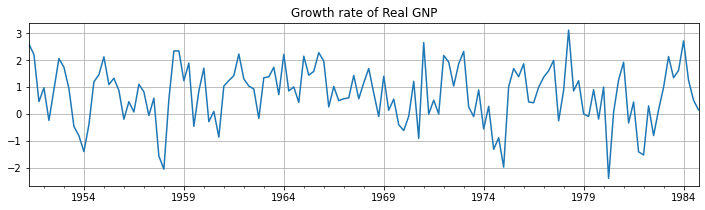

In [5]:
# Plot the data
dta_hamilton.plot(title='Growth rate of Real GNP', figsize=(12,3))
plt.grid()

Acá debemos detenernos y separar el proceso. Primero, creamos el objeto MarkovSwitching_FAE, con sus respectivos parametros, ya sea numero de observaciones *nobs*, la cantidad de regimenes *k_regimes*, etc. El punto importante es que k_params, nos entrega el numero de parametros que utilizaremos.

In [6]:
mod_hamilton = MarkovSwitching_FAE(dta_hamilton, k_regimes=2, order=4, switching_ar=False)

Una vez que el objeto se encuentra creado, se procede a realizar el ajuste con la función fit(). Uno de los puntos principales es la obtención de los parametros, 

In [7]:

def start_params(mod_hamilton):
    """
    (array) Parámetros iniciales para la estimación de máxima verosimilitud.
    """
    params = np.zeros(self.k_params, dtype=np.float64)

    # Transition probabilities
    if self.tvtp:
        params[self.parameters['regime_transition']] = 0.
    else:
        params[self.parameters['regime_transition']] = 1. / self.k_regimes

    endog = self.endog.copy()
    if self._k_exog > 0 and self.order > 0:
        exog = np.c_[self.exog, self.exog_ar]
    elif self._k_exog > 0:
        exog = self.exog
    elif self.order > 0:
        exog = self.exog_ar
    if self._k_exog > 0 or self.order > 0:
        beta = np.dot(np.linalg.pinv(exog), endog)
        variance = np.var(endog - np.dot(exog, beta))
    else:
        variance = np.var(endog)
    # Regression coefficients
    if self._k_exog > 0:
        if np.any(self.switching_coeffs):
            for i in range(self.k_regimes):
                params[self.parameters[i, 'exog']] = (
                        beta[:self._k_exog] * (i / self.k_regimes))
        else:
            params[self.parameters['exog']] = beta[:self._k_exog]
    # Autoregressive
    if self.order > 0:
        if np.any(self.switching_ar):
            for i in range(self.k_regimes):
                params[self.parameters[i, 'autoregressive']] = (
                        beta[self._k_exog:] * (i / self.k_regimes))
        else:
            params[self.parameters['autoregressive']] = beta[self._k_exog:]
    # Variance
    if self.switching_variance:
        params[self.parameters['variance']] = (
            np.linspace(variance / 10., variance, num=self.k_regimes))
    else:
        params[self.parameters['variance']] = variance

    return params

print('Parametros iniciales para Likelihood Evaluation:\n', mod_hamilton.start_params)

Parametros iniciales para Likelihood Evaluation:
 [ 0.5         0.5         0.          0.27839396  0.96679597  0.30974497
  0.12725767 -0.12125847 -0.0892264 ]


Donde los dos primeros valores corresponden al **regimen Transition**, el tercer y cuarto termino vienen dados por la variable **exog**, el quinto valor viene dado por la **varianza** y el sexto valor en adelante es dado por el parametro **beta**.
Lo principal del archivo MarkovSwitching_FAE, se encuentra dentro de la función .fit(), la cual se encarga de 'ajustar' el modelo. Para esto optimiza los valores iniciales para obtener 'Maximum likelihood estimation by scoring', junto con los algoritmos EM.

In [8]:
res_hamilton = mod_hamilton.fit()

In [9]:
print(res_hamilton.summary())

                         Markov Switching Model Results                        
Dep. Variable:                       y   No. Observations:                  131
Model:             MarkovSwitching_FAE   Log Likelihood                -181.263
Date:                 Wed, 15 Apr 2020   AIC                            380.527
Time:                         02:55:13   BIC                            406.404
Sample:                     04-01-1951   HQIC                           391.042
                          - 10-01-1984                                         
Covariance Type:                approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3588      0.265     -1.356      0.175      -0.877       0.160
                             Regime 1 parame

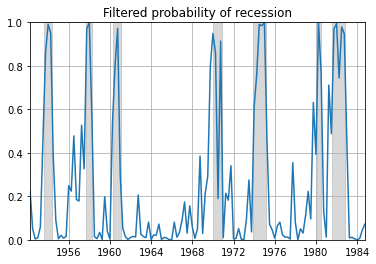

In [10]:
plt.plot(res_hamilton.filtered_marginal_probabilities[0])
plt.fill_between(usrec.index, 0, 1, where=usrec['USREC'].values, color='gray', alpha=0.3)
plt.xlim(dta_hamilton.index[4], dta_hamilton.index[-1])
plt.ylim(0, 1)
plt.title('Filtered probability of recession')
plt.grid()
plt.show()

'Filtered' se refiere a una estimación de la probabilidad a tiempo $t$ basado en la data incluyendo el tiempo $t$

In [11]:
print(res_hamilton.expected_durations)

[ 4.0760479 10.4258927]


En este caso, se espera que una recesión dure aproximadamente un año (4 trimestres) y una expansión de aproximadamente dos años y medio.

De manera similar es posible obtener resultados para el FedFunds.


In [12]:
from statsmodels.tsa.regime_switching.tests.test_markov_regression import fedfunds

dta_fedfunds = pd.Series(fedfunds, index=pd.date_range('1954-07-01', '2010-10-01', freq='QS'))

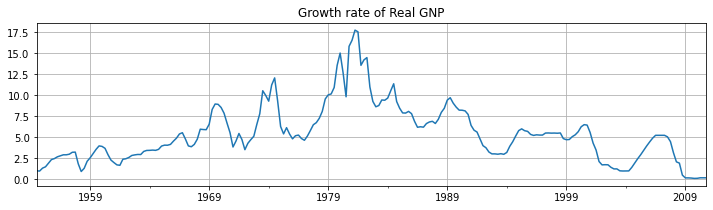

In [13]:
# Plot the data
dta_fedfunds.plot(title='Growth rate of Real GNP', figsize=(12,3))
plt.grid()

In [14]:
# Fit(). A switching mean is the default of the MarkovRegession model
mod_fedfunds = MarkovSwitching_FAE(dta_fedfunds, k_regimes=2, order=2)
res_fedfunds = mod_fedfunds.fit()

/home/juan/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [15]:
print(res_fedfunds.summary())


                         Markov Switching Model Results                        
Dep. Variable:                       y   No. Observations:                  224
Model:             MarkovSwitching_FAE   Log Likelihood                -242.243
Date:                 Wed, 15 Apr 2020   AIC                            502.485
Time:                         02:55:20   BIC                            533.190
Sample:                     07-01-1954   HQIC                           514.879
                          - 10-01-2010                                         
Covariance Type:                approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8110      1.167      8.410      0.000       7.525      12.098
ar.L1          0.8299      0.217      3.833 